In [20]:
import torch
import torch.functional as F
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
class BSpline(torch.nn.Module):
    def __init__(self, num_knots=10, degree=3):
        """Initialize a B-Spline

        Args:
            num_knots (int, optional): number of knots in B-spline. Defaults to 10.
            degree (int, optional): degree of polynomials. Defaults to 3.
        """
        super(BSpline, self).__init__()
        # should the knots be learnable?
        self.num_knots = num_knots

        self.degree = degree

        # initialize knots 
        self.knots = torch.cat([torch.zeros(3), torch.linspace(0, 1, num_knots - 6), torch.ones(3)])
        # put knots on the endpoints so they don't always evaluate to 0

        # learnable coefficients for each basis function
        num_coeficents = num_knots - 1 - degree
        self.coefficients = torch.nn.Parameter(torch.randn(num_coeficents))

    def basis_function(self, i, k, x):
        """Recursively perform linear interpolation to compute the B-spline basis function

        Args:
            i (int): index of the knot
            k (int): degree of the polynomial
            x (torch.Tensor): input value

        Returns:
            torch.Tensor: value of the basis function at x
        """
        if k == 0:
            # at base case, return 1 if x is in the interval [knots[i], knots[i + 1]) and 0 otherwise
            return ((x >= self.knots[i]) & (x < self.knots[i + 1])).float()
        else:
            # don't divide by zero...
            denominator_1 = self.knots[i + k] - self.knots[i]
            denominator_2 = self.knots[i + k + 1] - self.knots[i + 1]

            term_1 = 0 if denominator_1 == 0 else ((x - self.knots[i]) / denominator_1) * self.basis_function(i, k - 1, x)

            term_2 = 0 if denominator_2 == 0 else ((self.knots[i + k + 1] - x) / denominator_2) * self.basis_function(i + 1, k - 1, x)
            return term_1 + term_2

    def forward(self, x):
        """Forward pass of the B-spline"""
        n = len(self.coefficients)
        result = torch.zeros_like(x, dtype=torch.float32)
        for i in range(n):
            result += self.coefficients[i] * self.basis_function(i, self.degree, x)

        return result


degree = number of knots - number of control points (coefficients) - 1
number of coefficients = number of knots - degree - 1

In [22]:
# toy dataset
x = torch.linspace(0, 0.9999, 1000) # .9999 because the B-spline is defined on [0, 1) so it just evaluates to 0 at x = 1
y = torch.sin(x*5)

In [23]:
spline = BSpline(num_knots=10, degree=3)

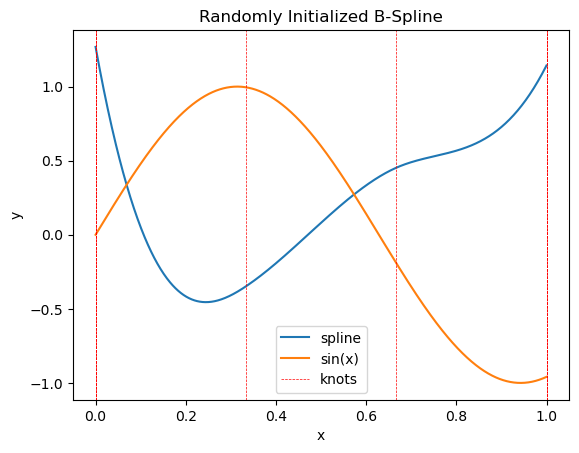

In [24]:
# plot the randomly initialized spline
spline_out = spline(x).detach()

plt.plot(x, spline_out)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Randomly Initialized B-Spline")

# insert verticle lines at the knots
for knot in spline.knots:
    plt.axvline(knot, color='r', linestyle='--', linewidth=0.5)

plt.legend(["spline", "sin(x)", 'knots'])

In [25]:
# fit spline to data
num_itrs = 1_000
lr = 0.01
optimizer = torch.optim.Adam(spline.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()
    spline_out = spline(x)
    loss = torch.nn.functional.mse_loss(spline_out, y)
    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}')

iteration 0, loss: 1.3053017854690552
iteration 50, loss: 0.6846573948860168
iteration 100, loss: 0.3237737715244293
iteration 150, loss: 0.13819630444049835
iteration 200, loss: 0.05422591418027878
iteration 250, loss: 0.02063703164458275
iteration 300, loss: 0.008408264257013798
iteration 350, loss: 0.0041146730072796345
iteration 400, loss: 0.002524489304050803
iteration 450, loss: 0.0018295894842594862
iteration 500, loss: 0.001442036358639598
iteration 550, loss: 0.001173223601654172
iteration 600, loss: 0.0009620033670216799
iteration 650, loss: 0.000787624972872436
iteration 700, loss: 0.0006418554694391787
iteration 750, loss: 0.0005202314350754023
iteration 800, loss: 0.0004194573266431689
iteration 850, loss: 0.0003366940363775939
iteration 900, loss: 0.0002693874412216246
iteration 950, loss: 0.00021522042516153306


Text(0.5, 1.0, 'Mean Squared Error (MSE) Loss of B-Spline Over 1000 Training Iterations')

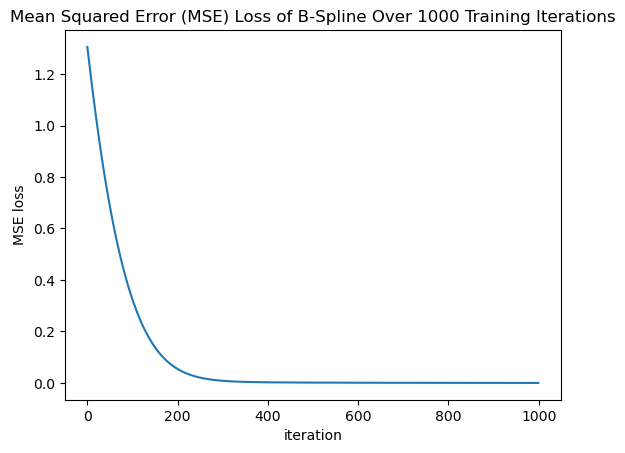

In [26]:
# plot losses
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('MSE loss')
plt.title(f'Mean Squared Error (MSE) Loss of B-Spline Over {num_itrs} Training Iterations')

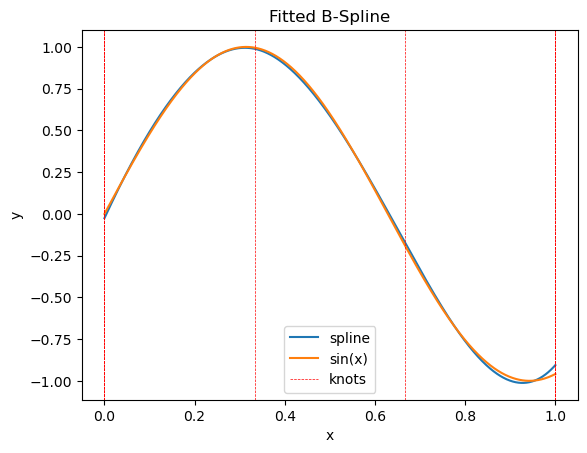

In [27]:
# plot the fitted spline
spline_out = spline(x).detach()

plt.plot(x, spline_out)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fitted B-Spline")

# insert verticle lines at the knots
for knot in spline.knots:
    plt.axvline(knot, color='r', linestyle='--', linewidth=0.5)

plt.legend(["spline", "sin(x)", 'knots'])

# GAM on Toy Dataset

In [28]:
# make toy dataset. in theory this could be modeled with a 1-layer KAN or a GAM with splines
num_samples = 100

transformations = [torch.sin, torch.log, lambda x: x**2]

num_features = len(transformations)

X = torch.rand(num_samples, num_features)

bias = torch.normal(mean=0, std=0.1, size=(1,))

# apply transformations to each feature and sum to get y
y = torch.sum(torch.stack([t(5 * X[:, i]) for i, t in enumerate(transformations)], dim=1), dim=1) + bias

# make sure no nan values
assert not torch.isnan(y).any()

X.shape, y.shape

(torch.Size([100, 3]), torch.Size([100]))

In [29]:
class GAM(torch.nn.Module):
    def __init__(self, num_features, num_knots=10, degree=3):
        """Initialize a Generalized Additive Model (GAM) with B-splines

        Args:
            num_features (int): number of features in the input
            num_knots (int, optional): number of knots in each B-spline. Defaults to 15.
            degree (int, optional): degree of the polynomial. Defaults to 3.
        """
        super(GAM, self).__init__()
        self.splines = [BSpline(num_knots=num_knots, degree=degree) for i in range(num_features)]

        self.bias = torch.nn.Parameter(torch.randn(1))

        # a little hacky; just so B-spline parameters are recognized by pytorch and learned
        self.parameters = nn.ParameterList([spline.coefficients for spline in self.splines])

    def forward(self, X):
        """Forward pass of the GAM"""
        return torch.sum(torch.stack([spline(X[:, i]) for i, spline in enumerate(self.splines)], dim=1), dim=1) + self.bias

In [30]:
gam = GAM(num_features=num_features)

In [31]:
# fit GAM to data
num_itrs = 5_000
lr = 0.01
optimizer = torch.optim.Adam(gam.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()
    gam_out = gam(X)
    loss = torch.nn.functional.mse_loss(gam_out, y)
    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}')

iteration 0, loss: 130.43853759765625
iteration 50, loss: 101.68722534179688
iteration 100, loss: 81.38716888427734
iteration 150, loss: 66.75198364257812
iteration 200, loss: 55.987037658691406
iteration 250, loss: 47.7756462097168
iteration 300, loss: 41.2401123046875
iteration 350, loss: 35.8636474609375
iteration 400, loss: 31.342336654663086
iteration 450, loss: 27.483774185180664
iteration 500, loss: 24.15683364868164
iteration 550, loss: 21.267230987548828
iteration 600, loss: 18.74428367614746
iteration 650, loss: 16.533082962036133
iteration 700, loss: 14.5896635055542
iteration 750, loss: 12.877998352050781
iteration 800, loss: 11.36803913116455
iteration 850, loss: 10.034404754638672
iteration 900, loss: 8.855463027954102
iteration 950, loss: 7.812666416168213
iteration 1000, loss: 6.8899993896484375
iteration 1050, loss: 6.0735764503479
iteration 1100, loss: 5.351290702819824
iteration 1150, loss: 4.71252965927124
iteration 1200, loss: 4.147950172424316
iteration 1250, loss

Text(0.5, 1.0, 'Mean Squared Error (MSE) Loss of GAM Over 5000 Training Iterations')

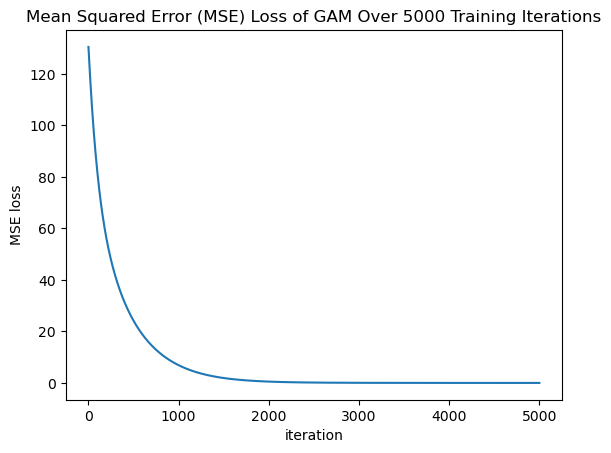

In [32]:
# plot losses
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('MSE loss')
plt.title(f'Mean Squared Error (MSE) Loss of GAM Over {num_itrs} Training Iterations')

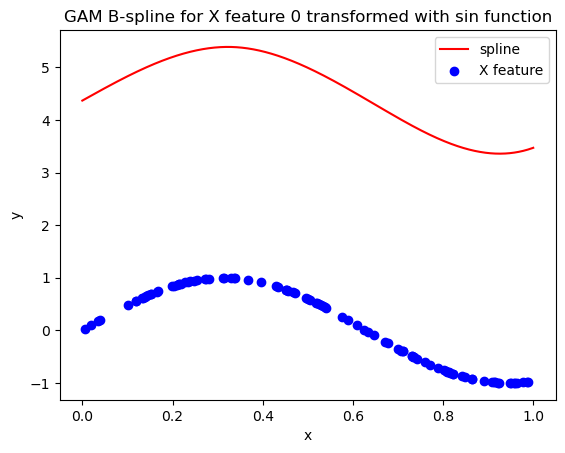

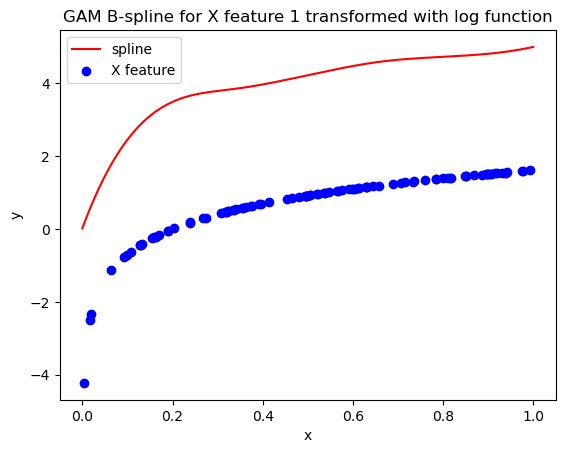

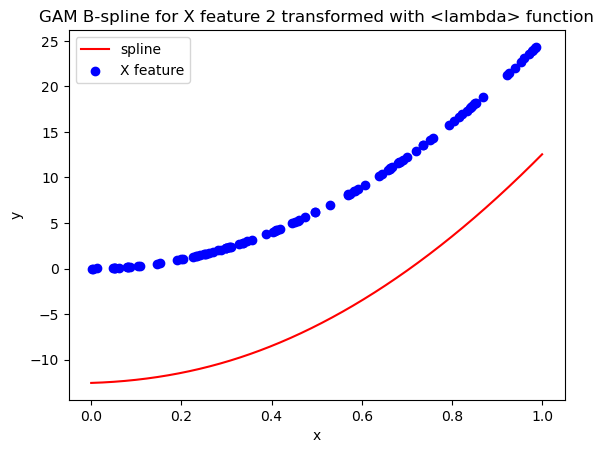

In [38]:
# plot splines

dummy_x = torch.linspace(0, 0.9999, 1000) # .9999 because the B-spline is defined on [0, 1) so it just evaluates to 0 at x = 1

for i, (spline, transformation) in enumerate(zip(gam.splines, transformations)):
    plt.plot(dummy_x, spline(dummy_x).detach(), c='r')
    
    x = X[:, i]
    plt.scatter(x, transformation(5 * x), c='b')
    plt.legend(["spline", "X feature"])

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"GAM B-spline for X feature {i} transformed with {transformation.__name__} function")

    plt.show()

# One Layer KAN

It seems like the only difference between a one-layer KAN and a B-spline based GAM is how the activations are implemented.

In a GAM each function of the features in just a B-spline which is evaluated, summed, and added to a bias term to get a final output

In a one-layer KAN, instead of simply a b-spline, we have:

$$
\phi(x) = w_b \cdot b(x) + w_s \cdot \text{spline}(x)
$$

for each feature.

Where b(x) is a basis function. In the paper, they just use a SiLU activation function for it and claim the reasoning for using it is the same as the reasoning for residual blocks; helps to reduce loss of input signal

Finally, wb and ws are learnable parameters that control the relative importance of each function and its associated feature. The authors explain that these two parameters are technically reduntant since they can be 'absorbed' into the spline and the basis but are nonetheless included to control the magnitude of the activation function. 



In [34]:
class OneLayerKAN(torch.nn.Module):
    def __init__(self, num_features, num_knots=10, degree=3, basis_function='silu'):
        """Initialize a one-layer Kolmogorov-Arnold Network (KAN)

        Args:
            num_features (int): number of features in the input
            num_knots (int, optional): number of knots in each B-spline. Defaults to 10.
            degree (int, optional): degree of the B-spline polynomials. Defaults to 3.
            basis_function (str, optional): basis function for each activation function. Defaults to 'silu'.
        """
        super(OneLayerKAN, self).__init__()
        # not bothering to initialize the way they do it in the paper
        self.splines = [BSpline(num_knots=num_knots, degree=degree) for i in range(num_features)]

        self.basis_function = getattr(torch.nn.functional, basis_function)
        
        self.parameters = nn.ParameterList([spline.coefficients for spline in self.splines])

        self.basis_coefficients = torch.nn.Parameter(torch.randn(num_features))
        self.spline_coefficients = torch.nn.Parameter(torch.randn(num_features))

    def forward(self, X):
        """Forward pass of the one-layer KAN"""
        # ϕ(x) = wb * b(x) + ws * spline(x)
        spline_output = torch.stack([spline(X[:, i]) for i, spline in enumerate(self.splines)], dim=1)
        spline_output_weighted = spline_output @ self.spline_coefficients

        basis_output = self.basis_function(X)
        basis_output_weighted = basis_output @ self.basis_coefficients
        
        # ϕ(x) = wb * b(x) + ws * spline(x)
        return basis_output_weighted + spline_output_weighted
    
    def get_activations(self, X):
        """
        Get the raw activations of the KAN without the final sum
        Useful for interpretability...
        """
        # obtain raw activations (basis + spline outputs) without final sum
        spline_output = torch.stack([spline(X[:, i]) for i, spline in enumerate(self.splines)], dim=1)
        spline_output_weighted = spline_output * self.spline_coefficients

        basis_output = self.basis_function(X)
        basis_output_weighted = basis_output * self.basis_coefficients
        
        return basis_output_weighted + spline_output_weighted    

In [35]:
kan = OneLayerKAN(num_features=num_features)

In [36]:
# fit KAN to data
num_itrs = 5_000
lr = 0.01
optimizer = torch.optim.Adam(kan.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()
    kan_out = kan(X)
    loss = torch.nn.functional.mse_loss(kan_out, y)
    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}')

iteration 0, loss: 194.9745330810547
iteration 50, loss: 128.00680541992188
iteration 100, loss: 75.4413070678711
iteration 150, loss: 44.9455451965332
iteration 200, loss: 25.06717300415039
iteration 250, loss: 11.771099090576172
iteration 300, loss: 5.251021862030029
iteration 350, loss: 2.596339702606201
iteration 400, loss: 1.4675400257110596
iteration 450, loss: 0.8952049016952515
iteration 500, loss: 0.5672246813774109
iteration 550, loss: 0.3695759177207947
iteration 600, loss: 0.24701274931430817
iteration 650, loss: 0.16914063692092896
iteration 700, loss: 0.11861991137266159
iteration 750, loss: 0.08530058711767197
iteration 800, loss: 0.0630631148815155
iteration 850, loss: 0.048106659203767776
iteration 900, loss: 0.03800418600440025
iteration 950, loss: 0.0311715267598629
iteration 1000, loss: 0.026554590091109276
iteration 1050, loss: 0.023442590609192848
iteration 1100, loss: 0.021351875737309456
iteration 1150, loss: 0.019951898604631424
iteration 1200, loss: 0.01901662

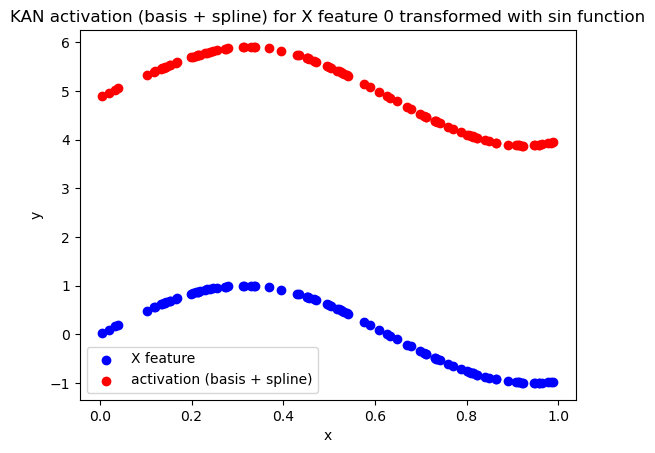

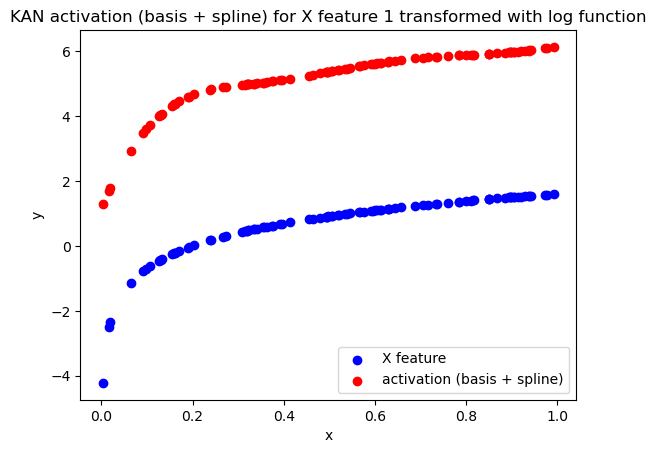

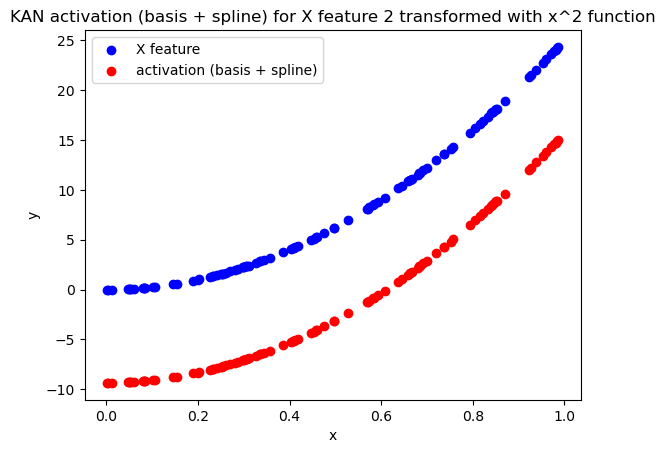

In [37]:
# plot kan activations
activations = kan.get_activations(X).detach().numpy()

transformation_names = ['sin', 'log', 'x^2']

for i, (feature_activation, transformation) in enumerate(zip(activations.T, transformations)):
    plt.scatter(X[:, i], transformation(5 * X[:, i]), c='b')
    plt.scatter(X[:, i], feature_activation, c='r')
    plt.legend(["X feature", "activation (basis + spline)"])

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"KAN activation (basis + spline) for X feature {i} transformed with {transformation_names[i]} function")

    plt.show()
